# DQN with `dm_control`

Here are some experiments using deep Q-Learning to solve simple continuous control tasks. I implemented [the original DQN](https://www.nature.com/articles/nature14236) and used it to solve several tasks in the [DeepMind Control Suite](https://arxiv.org/abs/1801.00690). The main ideas are:
1. Maintain a replay buffer of experiences that are drawn from for training. This decreases correlations in the training data.
2. Keep an additional Q network used for calculating targets that is updated less frequently that the main Q network. This stabalizes the updates.

Q-Learning takes the max across actions, which is not ideal for continuous action spaces. In this implementation the action space is discretized, such that each action dimension can take a value in `linspace(action_min, actions_max, action_grid)`, where `action_grid` $\in (2,3)$ in this demo. The full action space is the cartesian product of the vectors for each dimension.

The demo is organized as follows:
1. **setup**
2. **solving tasks:** pendulum, cartpole, ball in cup
3. **double DQN:** I implement [Double Q-Learning](https://arxiv.org/abs/1509.06461) and show that it increases the accuracy of action-value estimates.
4. **encouraging exploration:** To increase exploration I used a simple trick to encourage optimism in the face of uncertainty. Namely, I pretrained the network to output optimistic action-values across the state-space, which encourages exploration in the early phases of learning.  

# setup

We start by defining some utility functions that will help with plotting and training. To increase training speed I found it helpful to:
- *Train on the CPU rather than GPU.* The Q network is very small. My CPU was faster than the GPU unless batch sizes were really large.
- *Perform forward passes on Numpy*. Network forward passes ended up being much faster using numpy rather than Tensorflow (again, unless batch sizes were really large).
- *Train multiple agents in parallel*. Training results could be somewhat idiosyncratic even with the same hyperparameters, so I train 12 agents in parallel to make sure the results are robust.

In [161]:
#@title setup

%matplotlib inline
%load_ext autoreload
%autoreload 2

from concurrent.futures import ProcessPoolExecutor
from dm_control_tests.agents import Agent
from dm_control_tests import train_utils, plot_utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dm_control import suite
from itertools import repeat
import tensorflow as tf
import numpy as np
import pickle
import shutil
import os


tf.get_logger().setLevel('ERROR')
train_utils.disable_gpu()

# plot performance over training, averaged across agents
def plot_performance(x, data):
    ax = plt.axes(xlabel='episode', ylabel='return',
                  xlim=(x[0],x[-1]), ylim=(0,1000))
    data = np.array(data)
    if data.ndim==2:
        mean = data.mean(0)
        std = data.std(0)
        ax.plot(x, data.T, color=(0,0,0), alpha=.15)
        ax.plot(x, mean)
        ax.fill_between(x, mean+std, mean-std, alpha=.15)
    else:
        ax.plot(x, data)

# train multiple agents in parallel on a particular domain and task
def train_agents_parallel(domain_and_task, agent_args, train_args,
                          optimistic_q=None, n_agents=12, n_workers=12,
                          save_dir=None, overwrite=False):
    
    if save_dir is not None:
        if overwrite and os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        os.mkdir(save_dir)
        paths = ['{}/agent{:03d}'.format(save_dir, i) for i in range(n_agents)]
    else:
        repeat(None, n_agents)
    
    with ProcessPoolExecutor(max_workers=n_workers) as executor:    
        results = executor.map(train_utils.create_and_train_agent, 
                               repeat(domain_and_task, n_agents),
                               repeat(agent_args),
                               repeat(train_args),
                               repeat(optimistic_q),
                               paths,
                               [True]+list(repeat(False, n_agents-1)))  # only verbose for first thread
        results = [r for r in results]
    episode_num = results[0][0]
    avg_returns = np.array([np.array(r[1]).mean(1) for r in results])
    
    if save_dir is not None:
        training_data = {'episode_num': episode_num, 'avg_returns': avg_returns}
        with open(os.path.join(save_dir, 'training_data'), 'wb') as file:
            pickle.dump(training_data, file)
    
    return episode_num, avg_returns

# show a rollout for the agent with the best performance at the end of training
def show_best_agent_rollout(agents_dir, framerate=30):
    with open(os.path.join(agents_dir, 'training_data'), 'rb') as file:
        training_data = pickle.load(file)
    best_agent = np.argmax(training_data['avg_returns'][:,-1])
    agent, metadata = train_utils.load_agent(
        os.path.join(agents_dir, 'agent{:03d}'.format(best_agent)))
    env = suite.load(*metadata['domain_and_task'])
    return plot_utils.show_rollout_jupyter(agent, env, epsilon=.05, framerate=framerate)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### training
Let's set up the hyperparameters for training. Every action dimension will be discretized into `action_grid=2` actions. This makes training fast, but it also means a given action can't be set to `0`. We will use a replay buffer of size `buffer_length=50000` that is initialized using random actions prior to training and a Q network with hidden layers of size `units_per_layer=(12,24)`.  The target Q network will be updated after every `q_update_interval=100` updates of the main Q network.

The temporal resolution of the `dm_control` environments is rather high. During exploration, especially with sparse rewards, the sequence of correctly chosen actions necessary to discover the reward may be quite long. Therefore (as in the original paper), I repeat each action `action_repeats=2` times. Furthermore, I only perform network updates every `steps_per_update=4` iterations. The updates, rather than the physics simulations, are the speed bottleneck. This allows the agent to see more episodes with the same number of updates.

I train for `episodes=200` episodes with `batch_size=64`, acting $\epsilon$-greedy with $\epsilon$ linearly annealed from `epsilon_start=1` to `epsilon_final=.1` over `epsilon_final_episode=100` episodes.

### evaluation
Finally, every `eval_interval = 10` episodes I estimate the return by averaging the return from 5 rollouts with $\epsilon = .05$. $12$ agents are trained in parallel, and I plot the average += standard deviation of the return across these agents.

In [22]:
# @title hyperparameters 

# agent
agent_args = dict(
    action_grid = 2,            # number of discrete actions per action dimension
    units_per_layer = (12,24),  # hidden units per layer
    buffer_length = 50000,
    q_update_interval = 100,    # q updates per q_target update
    learning_rate = .001,       # learning rate (adam optimizer)       
)

# training
train_args = dict(
    episodes = 200,
    eval_interval = 10,
    batch_size = 64,
    action_repeats = 2,         # repeat each action this number of times during training
    steps_per_update = 4,       # environment steps before updating q
    gamma = .99,
    epsilon_start = 1,
    epsilon_final = .1,
    epsilon_final_episode = 100,   # episode at which epsilon_final is reached
)

# solving simple tasks
will solve pendulum, swing up, and ball in cup

## pendulum

training agent...


iteration   10, avg return  0.0
iteration   20, avg return  0.0
iteration   30, avg return 11.6
iteration   40, avg return  0.0
iteration   50, avg return  0.0
iteration   60, avg return  0.0
iteration   70, avg return  0.0
iteration   80, avg return  0.0
iteration   90, avg return  0.0
iteration  100, avg return  0.0
iteration  110, avg return  0.0
iteration  120, avg return 24.6
iteration  130, avg return 24.6
iteration  140, avg return  0.0
iteration  150, avg return 187.8
iteration  160, avg return 478.0
iteration  170, avg return 504.4
iteration  180, avg return 647.4
iteration  190, avg return 567.8
iteration  200, avg return 623.8



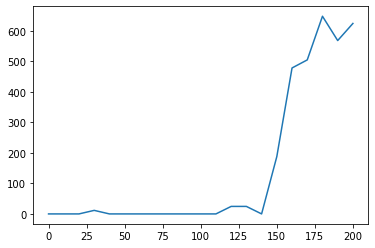

In [131]:
env = suite.load('pendulum', 'swingup')
train_utils.rand_seed_reset(env, 0)
agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
train_utils.initialize_buffer(agent, env, verbose=False)

train_args_temp = train_args.copy()
train_args_temp['episodes'] = 200
train_args_temp['epsilon_final_episode'] = 100
train_args_temp['gamma'] = 1
train_args_temp['epsilon_start'] = 1

# create state space grid points
bins = 40
angle_lims = (-np.pi/2, np.pi/2)
vel_lims = (-10,10)
axis_grids = [np.linspace(lims[0], lims[1], num=bins) for lims in (angle_lims, vel_lims)]
grid = np.array(np.meshgrid(*axis_grids)).reshape(2, -1).T
grid_predict = np.vstack((np.cos(grid[:,0]), np.sin(grid[:,0]), grid[:,1])).T  # first two columns are cos(x), sin(x) instead of x


def compute_prediction_grid(agent, env):
    q_map = agent.q.predict(grid_predict).reshape(bins, bins, 2)
    return q_map

episode_num, returns, q_maps = train_utils.train(
    agent, env, **train_args_temp, verbose=True, callback=compute_prediction_grid)
returns = [np.mean(r) for r in returns]
plot_performance(episode_num, returns);


In [168]:
preference_maps = [m[:,:,0] - m[:,:,1] for m in q_maps]
abs_max = np.abs(np.array(preference_maps)).max()
plot_utils.display_video(
    preference_maps, framerate=2, is_plot=True,
    imshow_args={'extent': angle_lims+vel_lims, 'cmap': 'bwr',
                 'vmin': -abs_max, 'vmax': abs_max},
    xlabel='angle', ylabel='velocity')

In [166]:
plot_utils.show_rollout_jupyter(agent, env, epsilon=0, rand_seed=5)

## cartpole (balance)

- state space only r2 and action space r1 - try this out to make sure everything is in order
- explain evaluation metrics... evaluated every n eps, avg of m eps with z epsilon

In [ ]:
episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'balance'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_balance', overwrite=True)
plot_performance(episode_num, avg_returns)

In [ ]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_balance')

## cartpole (swingup)

In [ ]:
episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_swingup', overwrite=True)
plot_performance(episode_num, avg_returns)

In [ ]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_swingup')

## ball in cup

In [ ]:
episode_num, avg_returns = train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/ball_in_cup', overwrite=True)
plot_performance(episode_num, avg_returns)

In [ ]:
show_best_agent_rollout('dm_control_tests/agents/ball_in_cup')

# double q learning
max operation leads to overly optimistic q values // double q have two q functions learned on dft data samples // dqn doesn't go this far, but uses it's two q functions for action selection and evaluation... increases accuracy of q estimates, as shown in pendulum...

In [ ]:
agent_args_dq = agent_args
agent_args_dq['double_dqn'] = True

episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args_dq, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_swingup_dq', overwrite=True)
plot_performance(episode_num, avg_returns)

In [ ]:
# todo: compare accuracy for dqn and double dqn

# optimistic initializations
for sparse reward agent needs to accidentally discover correct action sequence // can be very hard when that sequence is long // initializing optimisitic values of q can hopefully encourage initial exploration and speed up learning...

In [ ]:
episode_num, avg_returns, = train_agents_parallel(('cartpole', 'swingup'),
    agent_args, train_args, n_agents=12, n_workers=12, optimistic_q=100)
plot_performance(episode_num, avg_returns)

# sandbox...

initializing q with optimistic values...
pre training avg value: -0.03



post training avg value: 87.34
training agent...


iteration   10, avg return  0.0
iteration   20, avg return 11.6
iteration   30, avg return 23.6
iteration   40, avg return  0.0
iteration   50, avg return  1.6
iteration   60, avg return  0.0
iteration   70, avg return  0.0
iteration   80, avg return  0.0
iteration   90, avg return 13.0
iteration  100, avg return  0.0
iteration  110, avg return  0.0
iteration  120, avg return  0.0
iteration  130, avg return  0.0
iteration  140, avg return 11.4
iteration  150, avg return  0.0
iteration  160, avg return  0.0
iteration  170, avg return  0.0
iteration  180, avg return  0.0
iteration  190, avg return  6.0
iteration  200, avg return  0.0
iteration  210, avg return  0.0
iteration  220, avg return  2.2
iteration  230, avg return  0.0
iteration  240, avg return  2.0
iteration  250, avg return  0.0
iteration  260, avg return  0.0
iteration  270, avg return 45.2
iteration  280, avg return 29.8
iteration  290, avg return 52.0
iteration  300, avg return  4.4
iteration  310, avg return 81.6
iteratio

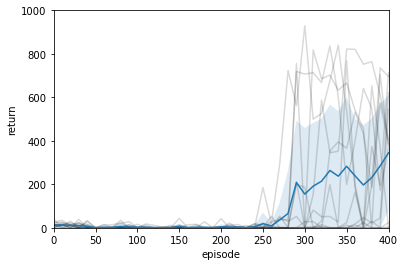

In [3]:
# try pendulum in parallel
train_args_pend = train_args.copy()
train_args_pend['epsilon_start'] = .5
train_args_pend['episodes'] = 400

episode_num, avg_returns = train_agents_parallel(
    ('pendulum', 'swingup'), agent_args, train_args_pend, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/pendulum_swingup', overwrite=True, optimistic_q=100)
plot_performance(episode_num, avg_returns)

In [5]:
train_utils.rand_seed_reset(1)
show_best_agent_rollout('dm_control_tests/agents/pendulum_swingup')

In [14]:
# env = suite.load('point_mass', 'easy')
# env.observation_spec()
# agent = Agent(env.observation_spec(), env.action_spec())
# train_utils.initialize_buffer(agent, env)
# np.array([x[0] for x in agent.replay_buffer]).min(0)

array([-0.29024393, -0.29073602, -0.05072378, -0.06724515])